## 9. Final model evaluation and interpretation

Now that the model is trained, we return to our constraints—one of which is high interpretability. We want to understand the model’s decisions so we can compare them to our existing biomedical knowledge. This is precisely why we avoided neural networks: interpreting their internal weights and activations is very difficult, and a black‐box approach offers little insight into how specific clinical variables drive each individual prediction. By using a tree‐based method like XGBoost, we can leverage post-hoc explanation techniques (such as SHAP) to quantify each feature’s contribution to the final decision.

In this next step, we will compute feature-level importance scores for every prediction, highlighting which biomarkers, demographic factors, or lab results push the model toward one outcome or another. Once we have those importance scores, we can rank the top contributors for each patient and then aggregate them across a cohort to see which features the model relies on most overall. Finally, we’ll compare this model-derived ranking to the set of risk factors that clinicians typically consider—checking for both alignment (e.g., HbA1c or BMI appearing near the top) and any surprising discrepancies (e.g., a lab value clinicians don’t usually emphasize). By doing so, we ensure that our predictive pipeline not only performs well but also remains transparent, trustworthy, and grounded in real-world medical expertise.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_thresholds(model, X_test=None):
    booster = model.get_booster()
    trees_df = booster.trees_to_dataframe()

    # This if condition is to ensure that the features match the size of X_test 
    if X_test is not None:
        model_feats = set(booster.feature_names)
        test_feats = set(X_test.columns)
        missing = model_feats - test_feats
        if len(missing) > 0:
            raise ValueError(f"The next features are missing on test: {missing}")

    # Here we  build a DataFrame with the tree structure
    arrels_df = trees_df[trees_df["Node"] == 0].sort_values("Tree").copy()

    # We build an array of stumps (trees of depth 1)
    # In order to anlayze all components of the tree, we will extract:
    #   - Tree: the index of the tree.
    #   - Feature: the predictor used.
    #   - Split: the numeric threshold of the split.
    #   - Gain_split: the improvement of the objective obtained by this split (column "Gain"). 
    #   - LeafLeft: if we fall into the left branch (Yes), the leaf value (column "Gain" where Feature='Leaf').
    #   - LeafRight: if we fall into the right branch (No), the leaf value (also column "Gain").

    stumps = []
    for idx, fil in arrels_df.iterrows():
        tree_idx = int(fil["Tree"])
        feat      = fil["Feature"]
        threshold = float(fil["Split"]) if pd.notnull(fil["Split"]) else None
        gain_split= float(fil["Gain"])           
        yes_raw = fil["Yes"]
        no_raw  = fil["No"]
        try:
            yes_node = int(str(yes_raw).split("-")[-1])
        except:
            yes_node = int(yes_raw)
        try:
            no_node = int(str(no_raw).split("-")[-1])
        except:
            no_node = int(no_raw)

        # Search for the leaf values in the DataFrame:
        leaf_left_vals  = trees_df[(trees_df["Tree"] == tree_idx) & (trees_df["Node"] == yes_node)]["Gain"].values
        leaf_right_vals = trees_df[(trees_df["Tree"] == tree_idx) & (trees_df["Node"] == no_node)]["Gain"].values

        if len(leaf_left_vals) != 1 or len(leaf_right_vals) != 1:
            raise ValueError(
                f"Error: for tree ={tree_idx}, "
                f"yes_node={yes_node} (found {len(leaf_left_vals)} matches), "
                f"no_node={no_node} (found {len(leaf_right_vals)} matches)."
            )

        leaf_left_val  = float(leaf_left_vals[0])
        leaf_right_val = float(leaf_right_vals[0])

        stumps.append({
            "Tree": tree_idx,
            "Feature": feat,
            "Threshold": threshold,
            "Gain_split": gain_split,
            "LeafLeft": leaf_left_val,
            "LeafRight": leaf_right_val
        })

    stumps_df = pd.DataFrame(stumps).sort_values("Tree").reset_index(drop=True)
    print(f"\nS’han extret {len(stumps_df)} stumps (arbres de profunditat 1):\n")
    display(stumps_df)

    # We compute the maximum absolute value of the leaf values and the weighted score
    # (Gain_split × MaxAbsLeaf) for each feature.
    stumps_df["MaxAbsLeaf"]    = stumps_df[["LeafLeft", "LeafRight"]].abs().max(axis=1)
    stumps_df["WeightedScore"] = stumps_df["Gain_split"] * stumps_df["MaxAbsLeaf"]
    agg = stumps_df.groupby("Feature")["WeightedScore"].sum().reset_index()
    agg = agg.sort_values("WeightedScore", ascending=False)

    print("\nSum of (Gain_split × MaxAbsLeaf) per feature:\n")
    display(agg)

    top_k = len(agg)
    plt.figure(figsize=(6, top_k * 0.3))
    plt.barh(agg["Feature"][::-1], agg["WeightedScore"][::-1], color="#2ca02c", edgecolor="black")
    plt.xlabel("Sum(Gain_split × |LeafValue|) per feature", fontsize=9)
    plt.title("Importance per feature → thresholds + leaf‐values", fontsize=10)
    plt.tight_layout()
    plt.show()

    return stumps_df, agg

In [2]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

def interpret_model_full(
    model,
    X_test: pd.DataFrame,
    y_test: pd.Series = None,
    class_names: list = None,
    force_plot_indices: list = None,
    max_summary_features: int = 20,
    pdp_features: list = None,
    decision_plot_n: int = 50,
    do_thresholds: bool = False
):

    # Check to avoid errors
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame (with the same columns used at training).")
    if y_test is not None and len(y_test) != X_test.shape[0]:
        raise ValueError("y_test length must match X_test length.")
    for feat in (pdp_features or []):
        if feat not in X_test.columns:
            raise ValueError(f"pdp_features includes '{feat}' which is not in X_test.columns.")
    if force_plot_indices is not None:
        for i in force_plot_indices:
            if i < 0 or i >= X_test.shape[0]:
                raise ValueError(f"force_plot_indices contains {i} which is outside [0, {X_test.shape[0]-1}].")

    
    # Use shap library to compute values
    print("\n--- 1) Computing SHAP values (this can take a few seconds) ---")
    explainer = shap.TreeExplainer(model)
    raw_shap = explainer.shap_values(X_test)
    if isinstance(raw_shap, list) and len(raw_shap) == 2:
        shap_values = raw_shap[1]
    else:
        shap_values = raw_shap

    # Do a summary plot to visualize feature importance
    print("\n--- 2) SHAP summary (violin) plot ---")
    shap.summary_plot(
        shap_values,
        X_test,
        feature_names=X_test.columns.tolist(),
        plot_type="violin",
        max_display=max_summary_features,
        cmap="RdBu",
        show=True
    )

    # Compute XGBoost built‐in feature importance (F‐score / "weight")
    print("\n--- 3) XGBoost feature‐importance (F‐score) bar chart ---")
    booster = model.get_booster()
    imp_dict = booster.get_score(importance_type="weight")  # F‐score = number of times it appears in splits
    imp_df = pd.DataFrame.from_dict(imp_dict, orient="index", columns=["f_score"])
    imp_df.index.name = "feature"
    imp_df = imp_df.reset_index().sort_values("f_score", ascending=False)

    # Plot only top 20 features (for cases B and C, there are many features)
    top_k = min(len(imp_df), 20)
    imp_bar = imp_df.iloc[:top_k]

    plt.figure(figsize=(6, top_k * 0.3))
    bars = plt.barh(
        y=imp_bar["feature"][::-1],
        width=imp_bar["f_score"][::-1],
        color="#1f77b4",
        edgecolor="black"
    )
    for bar in bars:
        w = bar.get_width()
        plt.text(
            w + max(imp_bar["f_score"]) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{int(w)}",
            va="center",
            fontsize=7
        )
    plt.xlabel("F‐score (split count)", fontsize=9)
    plt.title("XGBoost Feature Importance (F‐score)", fontsize=10)
    plt.yticks(fontsize=7)
    plt.xticks(fontsize=7)
    plt.tight_layout()
    plt.show()

    # Do some SHAP force plots for specific indices (if provided)
    # Force plot are useful to undesrtand how each feature contributes to the prediction of each indvidual case
    if force_plot_indices is not None and len(force_plot_indices) > 0:
        print(f"\n--- 4) SHAP force_plots for indices {force_plot_indices} ---")
        for idx in force_plot_indices:
            single_X    = X_test.iloc[[idx]]
            single_shap = shap_values[idx, :]   # shape = (n_features,)
            # Determine the “base value” for class 1:
            if isinstance(explainer.expected_value, list):
                base_value = explainer.expected_value[1]
            else:
                base_value = explainer.expected_value

            print(f"\nForce plot for sample index = {idx}, true_label = "
                  f"{(y_test.iloc[idx] if y_test is not None else 'N/A')}")
            shap.initjs()
            shap.force_plot(
                base_value,
                single_shap,
                single_X,
                feature_names=X_test.columns.tolist(),
                matplotlib=True,
                show=True
            )

    
    # SHAP decision_plot for the first `decision_plot_n` samples
    n_decision = min(decision_plot_n, X_test.shape[0])
    if n_decision > 0:
        print(f"\n--- 5) SHAP decision_plot for first {n_decision} samples ---")
        base_value = explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value
        shap.decision_plot(
            base_value,
            shap_values[:n_decision, :],
            X_test.iloc[:n_decision, :],
            feature_names=X_test.columns.tolist(),
            highlight=None,
            show=True,
            title=f"Decision plot (first {n_decision} samples)"
        )

    # Partial dependence plots
    # This are useful to understand how the values of a certain feature affect the model's predictions
    # And where the threshold is
    if pdp_features is not None and len(pdp_features) > 0:
        print(f"\n--- 6) Partial‐dependence plots for features {pdp_features} ---")
        pdp_estimator = model
        for feat in pdp_features:
            if feat not in X_test.columns:
                continue
            fig, ax = plt.subplots(figsize=(6, 3))
            PartialDependenceDisplay.from_estimator(
                pdp_estimator,
                X_test,
                [feat],
                kind="average",
                target=1,       # “1” means we want PDP for the positive class probability
                grid_resolution=50,
                ax=ax
            )
            ax.set_title(f"Partial Dependence of P(class=1) on feature '{feat}'")
            plt.tight_layout()
            plt.show()


    # Here we call the `analyze_thresholds` function if requested
    if do_thresholds:
        print("\n--- 7) Threshold‐based analysis via analyze_thresholds() ---")
        try:
            # We assume that `analyze_thresholds` is already defined in this notebook/module.
            stumps_df, agg_df = analyze_thresholds(model, X_test)
            # Optionally, you could return these or just display them here.
        except NameError:
            raise NameError(
                "You passed do_thresholds=True but `analyze_thresholds` is not defined. "
                "Please make sure `analyze_thresholds(model, X_test)` is available in scope."
            )

    print("\n=== Done interpreting model ===\n")


In [6]:
X_test_C         = pd.read_pickle("outputs/X_test_C.pkl")
y_test_C         = pd.read_pickle("outputs/y_test_C.pkl")
X_test_B           = pd.read_pickle('outputs/X_test_B.pkl')
y_test_B           = pd.read_pickle('outputs/y_test_B.pkl')


--- 1) Computing SHAP values (this can take a few seconds) ---

--- 2) SHAP summary (violin) plot ---


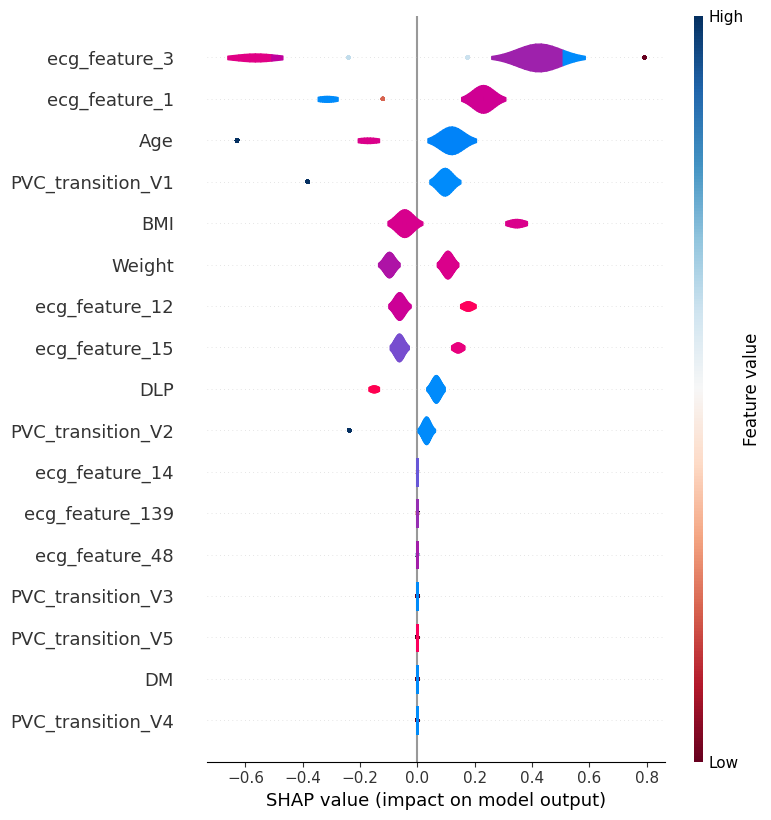


--- 3) XGBoost feature‐importance (F‐score) bar chart ---


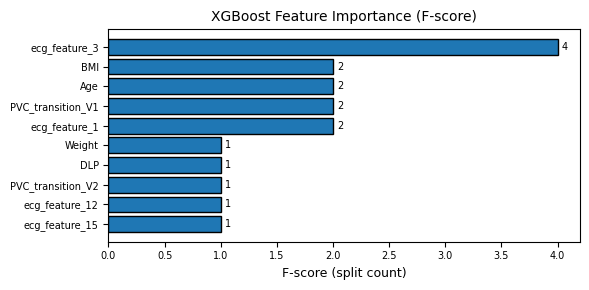


--- 4) SHAP force_plots for indices [0, 5, 13] ---

Force plot for sample index = 0, true_label = RVOT


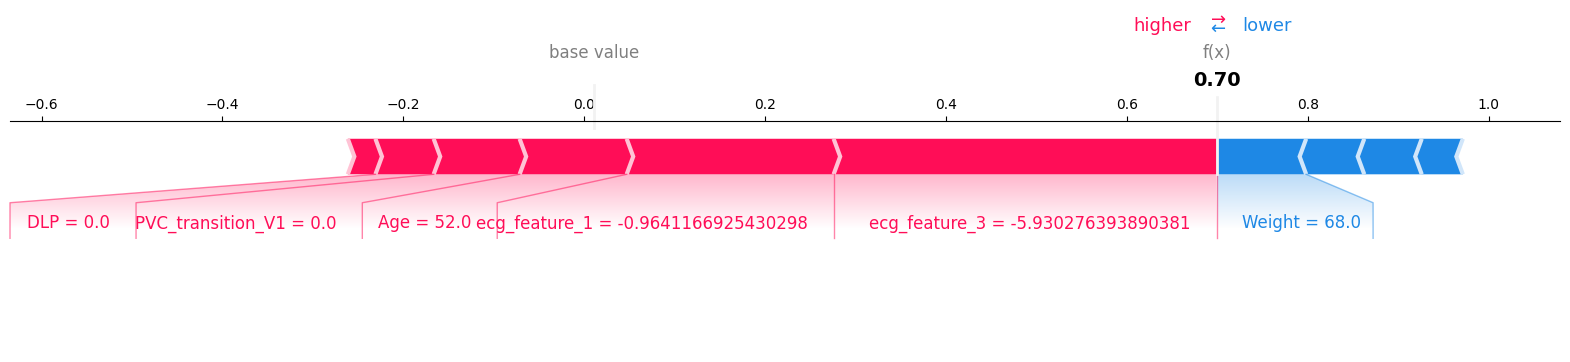


Force plot for sample index = 5, true_label = RVOT


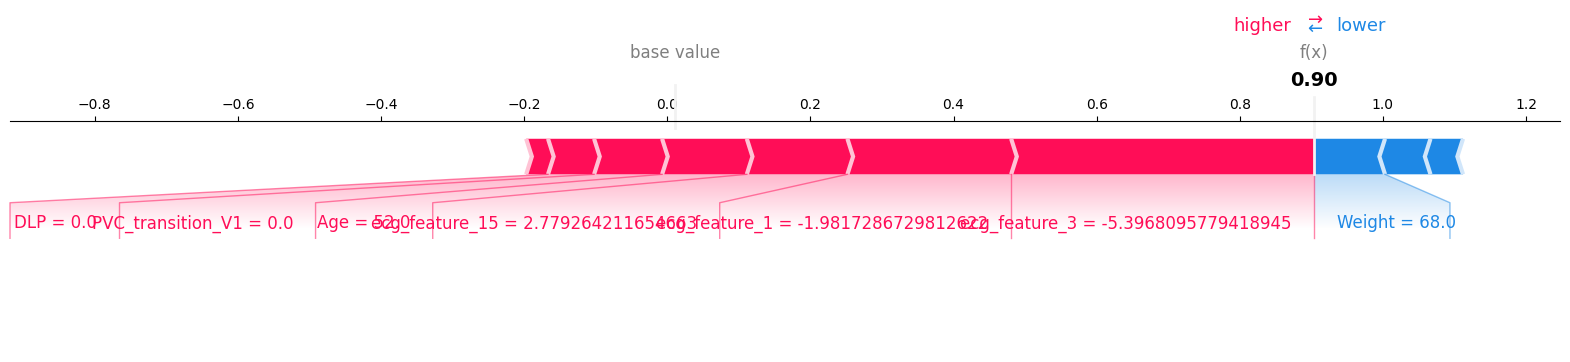


Force plot for sample index = 13, true_label = RVOT


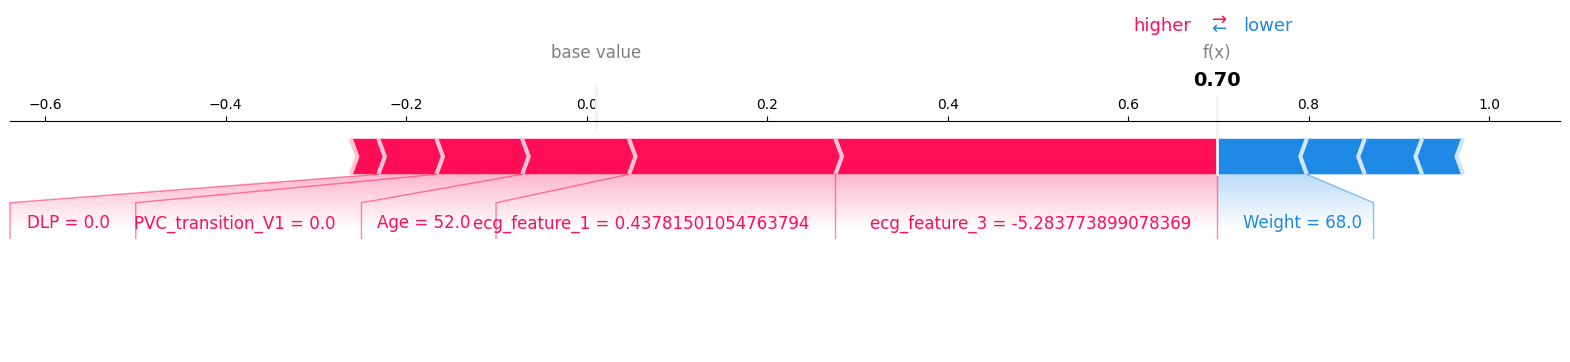


--- 5) SHAP decision_plot for first 50 samples ---


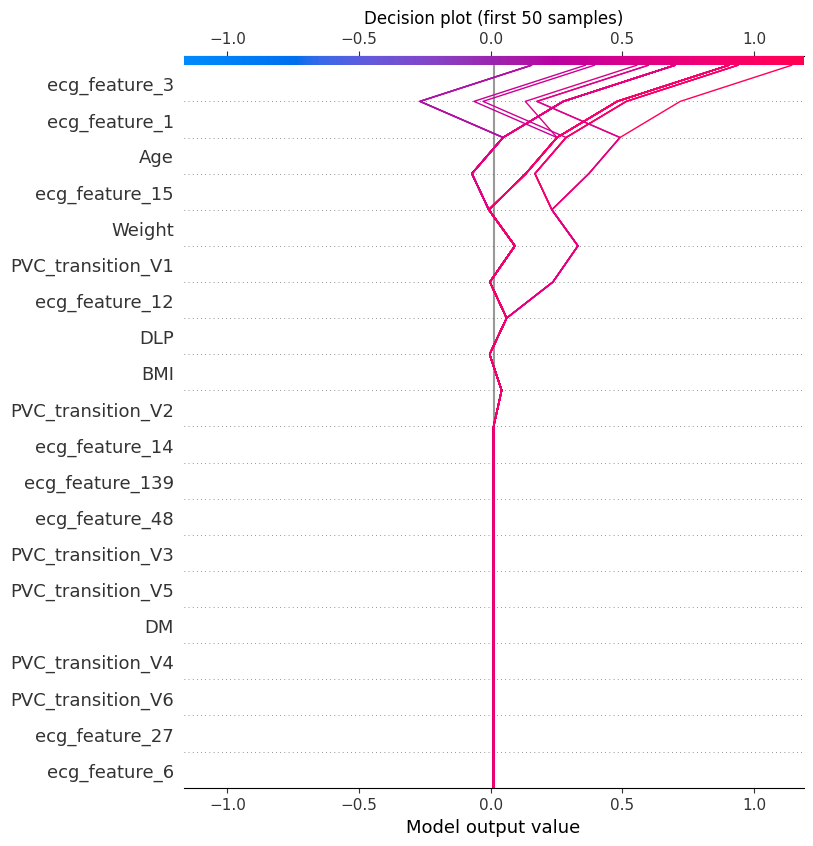


--- 6) Partial‐dependence plots for features ['ecg_feature_3', 'Age'] ---


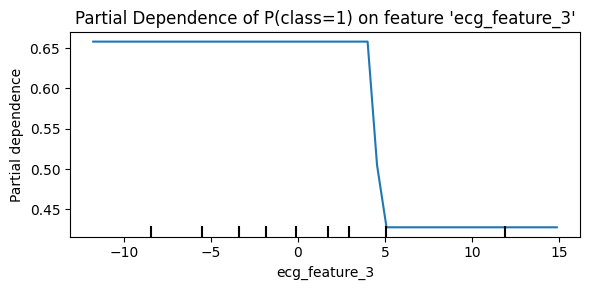

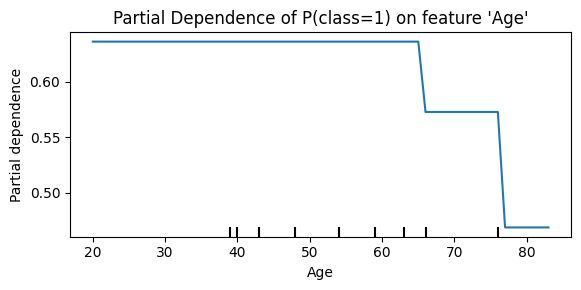


--- 7) Threshold‐based analysis via analyze_thresholds() ---

S’han extret 17 stumps (arbres de profunditat 1):



Tree            Feature  Threshold   Gain_split  LeafLeft  LeafRight
0      0      ecg_feature_1  -3.106818  1514.442870 -0.193431   0.155859
1      1      ecg_feature_3   4.521137  2197.842290  0.190455  -0.225560
2      2      ecg_feature_3   4.888997  1306.818480  0.146121  -0.177934
3      3                Age  66.000000   885.237610  0.094211  -0.196602
4      4      ecg_feature_3   4.340495   732.614807  0.114907  -0.132603
5      5                Age  77.000000   553.916565  0.032048  -0.424756
6      6     ecg_feature_12   2.415969   514.523499 -0.064099   0.175328
7      7      ecg_feature_3 -13.179709   519.263611  0.330559  -0.038496
8      8  PVC_transition_V1   1.000000   469.366913  0.045878  -0.207927
9      9      ecg_feature_1  -3.164467   423.351135 -0.118189   0.077075
10    10             Weight  75.500000   463.528320 -0.097513   0.106620
11    11                BMI  22.093170   434.751129  0.364976  -0.025397
12    12                DLP   1.000000   429.780548  0.066392  -0.149973
13    13     ecg_feature_15   1.721602   399.554810 -0.064818   0.140010
14    14  PVC_transition_V2   1.000000   315.380219  0.038411  -0.230236
15    15                BMI  33.029461   321.400635 -0.020008   0.389403
16    16  PVC_transition_V1   1.000000   343.689636  0.047964  -0.175554


Sum of (Gain_split × MaxAbsLeaf) per feature:



Feature  WeightedScore
9      ecg_feature_3     997.066337
0                Age     409.319126
6      ecg_feature_1     342.975499
1                BMI     283.828113
3  PVC_transition_V1     157.930202
7     ecg_feature_12      90.210461
4  PVC_transition_V2      72.611789
2                DLP      64.455538
8     ecg_feature_15      55.941496
5             Weight      49.421303

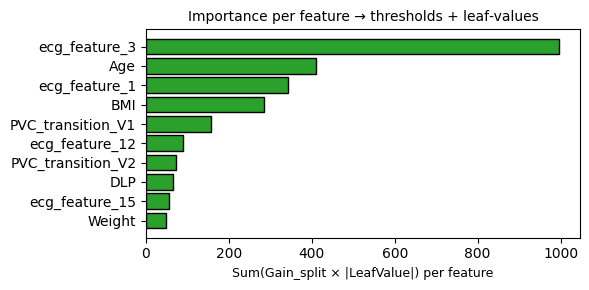


=== Done interpreting model ===



In [7]:
import xgboost as xgb

model_b_lite = xgb.XGBClassifier()
model_b_lite.load_model("models/model_b_lite/xgb_best_optuna.json")

feature_names = model_b_lite.get_booster().feature_names

# Subset X_test_B to only those columns, in the correct order, this is to ensure compatibility
X_test_B_lite = X_test_B[feature_names]

interpret_model_full(
    model=model_b_lite,
    X_test=X_test_B_lite,
    y_test=y_test_B,
    class_names=['LVOT','RVOT'],
    force_plot_indices=[0, 5, 13],
    max_summary_features=17,
    pdp_features=['ecg_feature_3', 'Age'],
    decision_plot_n=50,
    do_thresholds=True 
)


--- 1) Computing SHAP values (this can take a few seconds) ---

--- 2) SHAP summary (violin) plot ---


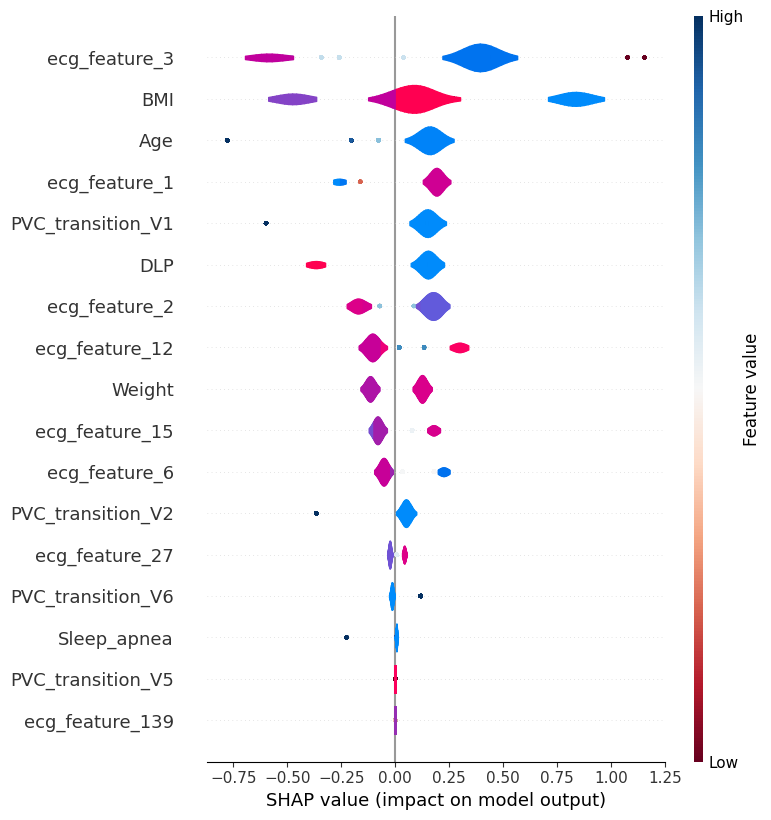


--- 3) XGBoost feature‐importance (F‐score) bar chart ---


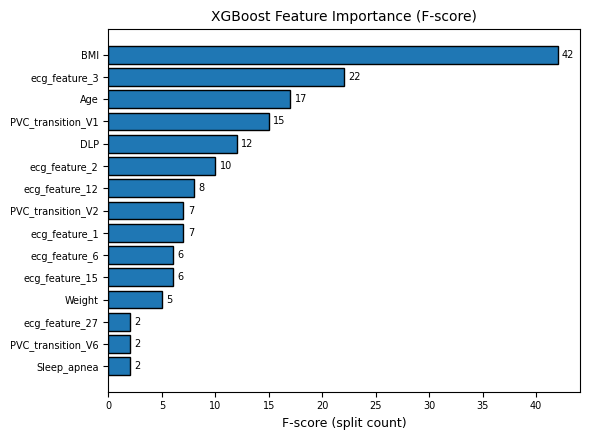


--- 4) SHAP force_plots for indices [0, 5, 13] ---

Force plot for sample index = 0, true_label = RVOT


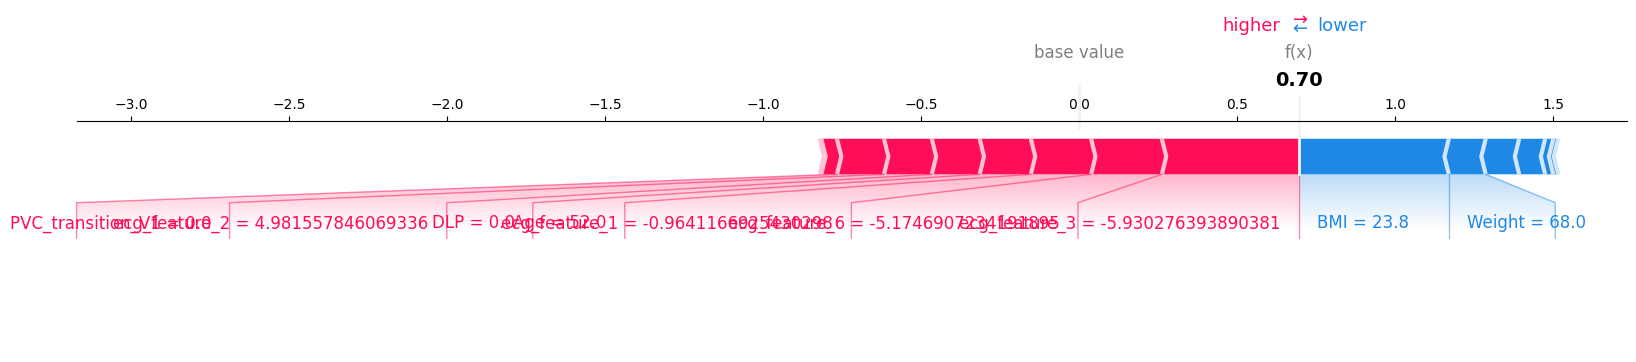


Force plot for sample index = 5, true_label = RVOT


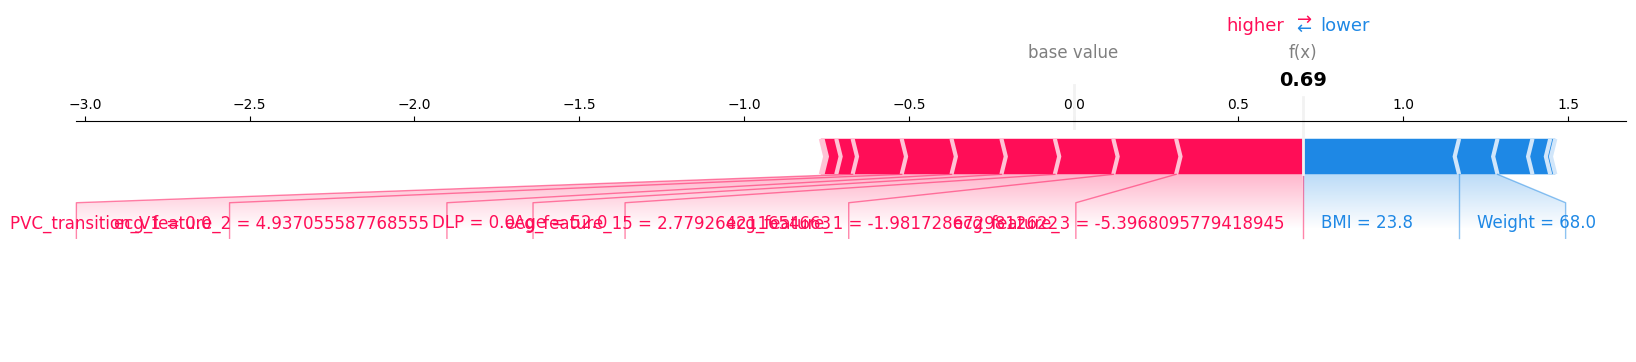


Force plot for sample index = 13, true_label = RVOT


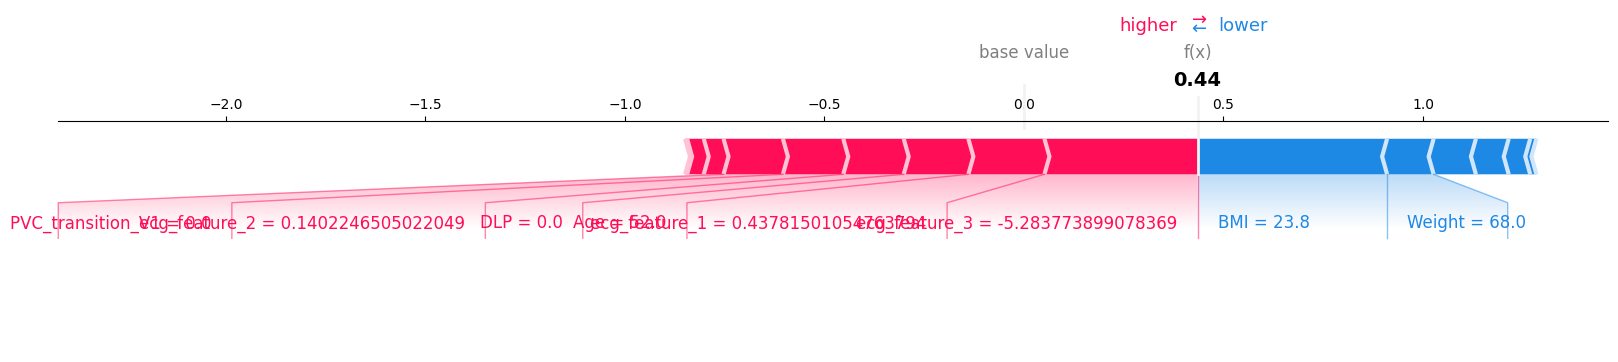


--- 5) SHAP decision_plot for first 50 samples ---


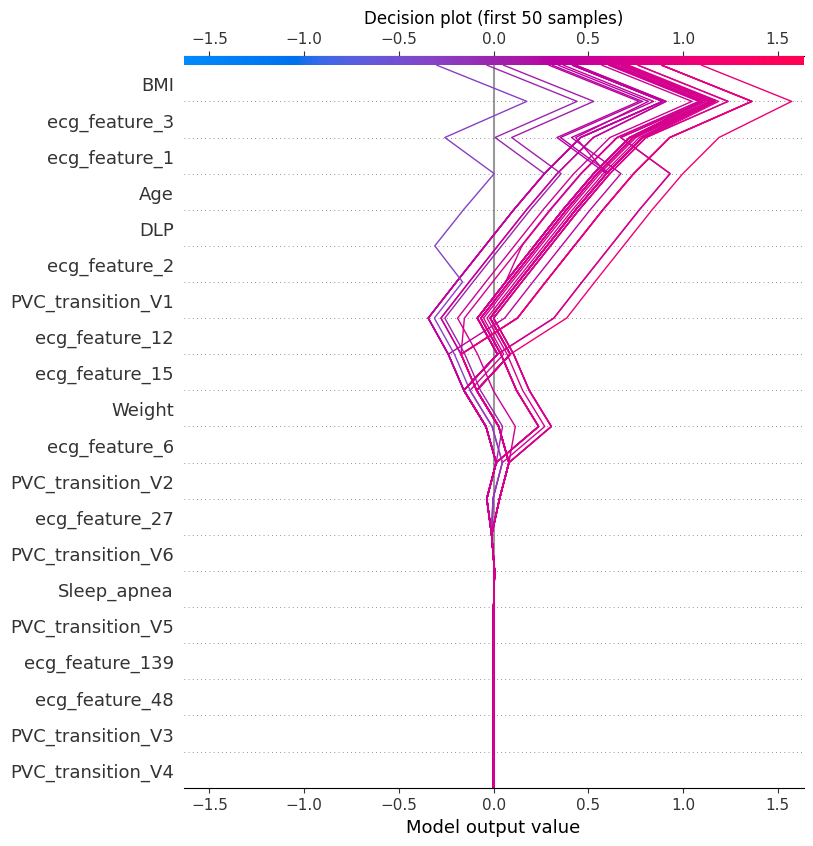


--- 6) Partial‐dependence plots for features ['ecg_feature_3', 'Age'] ---


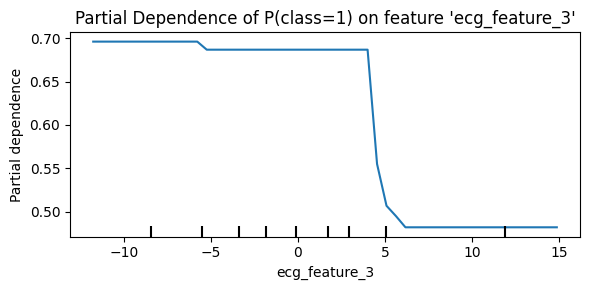

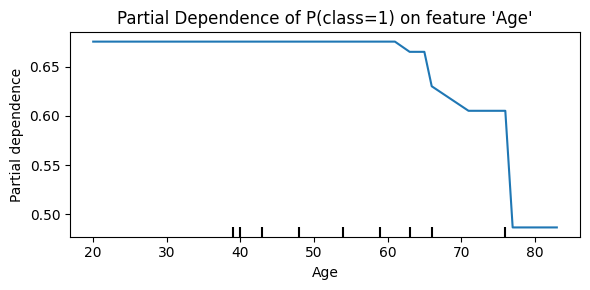


=== Done interpreting model ===



In [8]:
model_b = xgb.XGBClassifier()
model_b.load_model("models/model_b/xgb_best_optuna.json")

feature_names = model_b.get_booster().feature_names

# Subset X_test_B to only those columns, in the correct order, this is to ensure compatibility
X_test_B_test = X_test_B[feature_names]

interpret_model_full(
    model=model_b,
    X_test=X_test_B_test,
    y_test=y_test_B,
    class_names=['LVOT','RVOT'],
    force_plot_indices=[0, 5, 13],
    max_summary_features=17,
    pdp_features=['ecg_feature_3', 'Age'],
    decision_plot_n=50
)


--- 1) Computing SHAP values (this can take a few seconds) ---

--- 2) SHAP summary (violin) plot ---


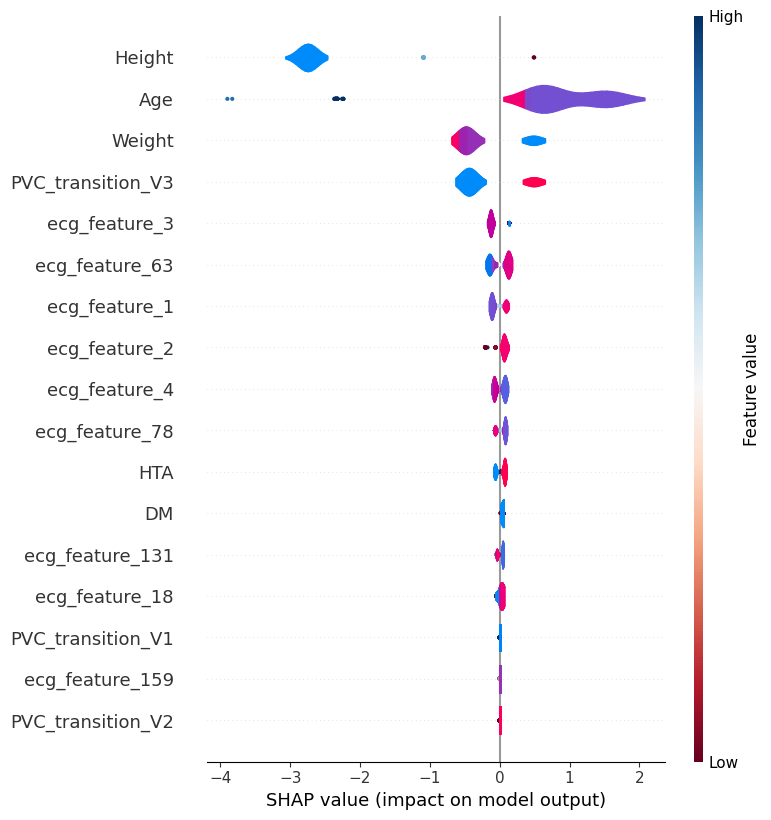


--- 3) XGBoost feature‐importance (F‐score) bar chart ---


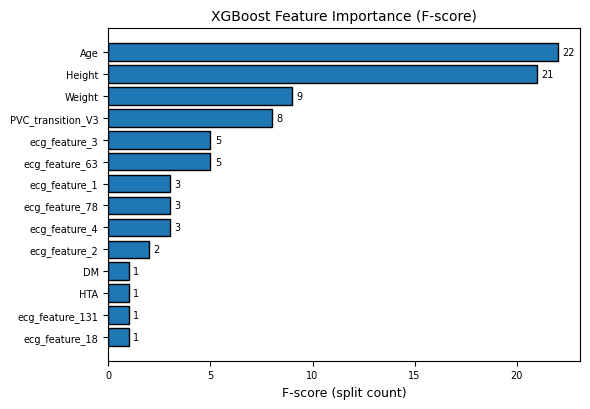


--- 4) SHAP force_plots for indices [0, 5, 13] ---

Force plot for sample index = 0, true_label = RCC


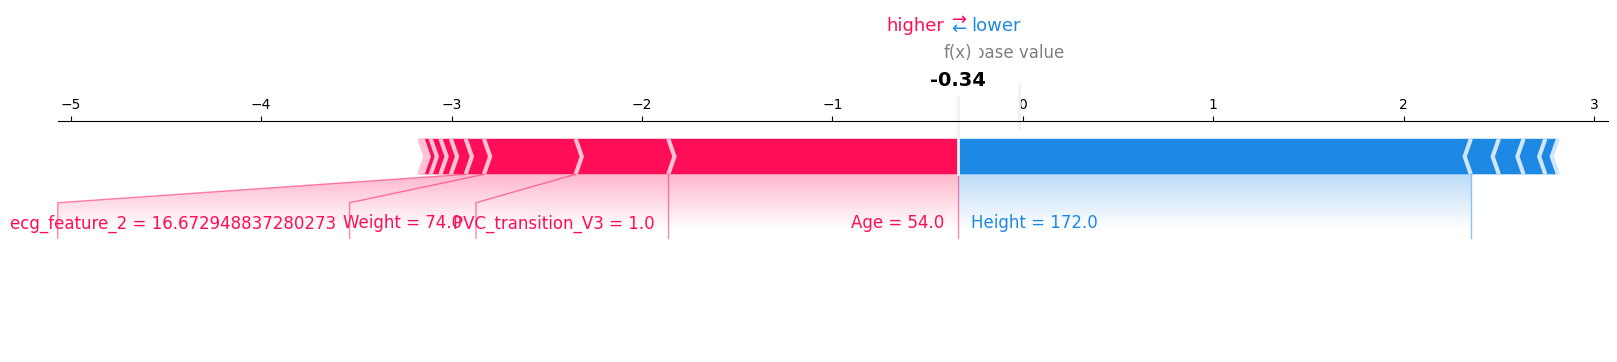


Force plot for sample index = 5, true_label = RCC


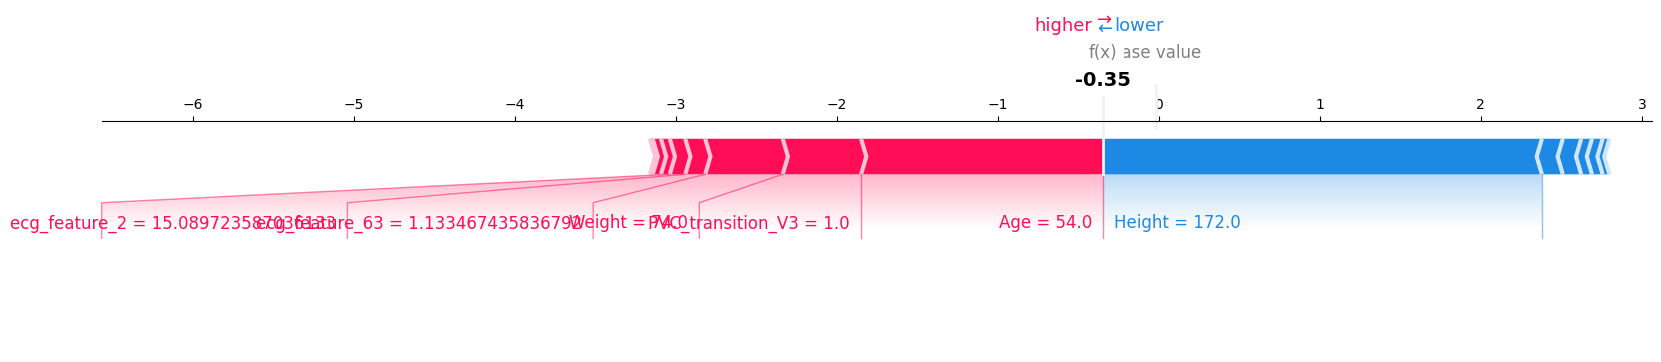


Force plot for sample index = 13, true_label = RCC


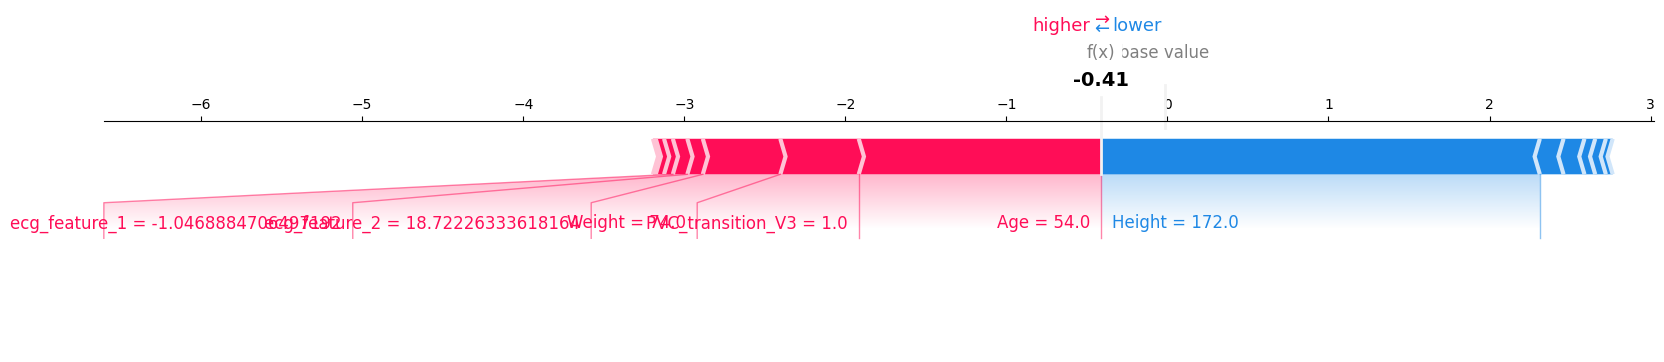


--- 5) SHAP decision_plot for first 50 samples ---


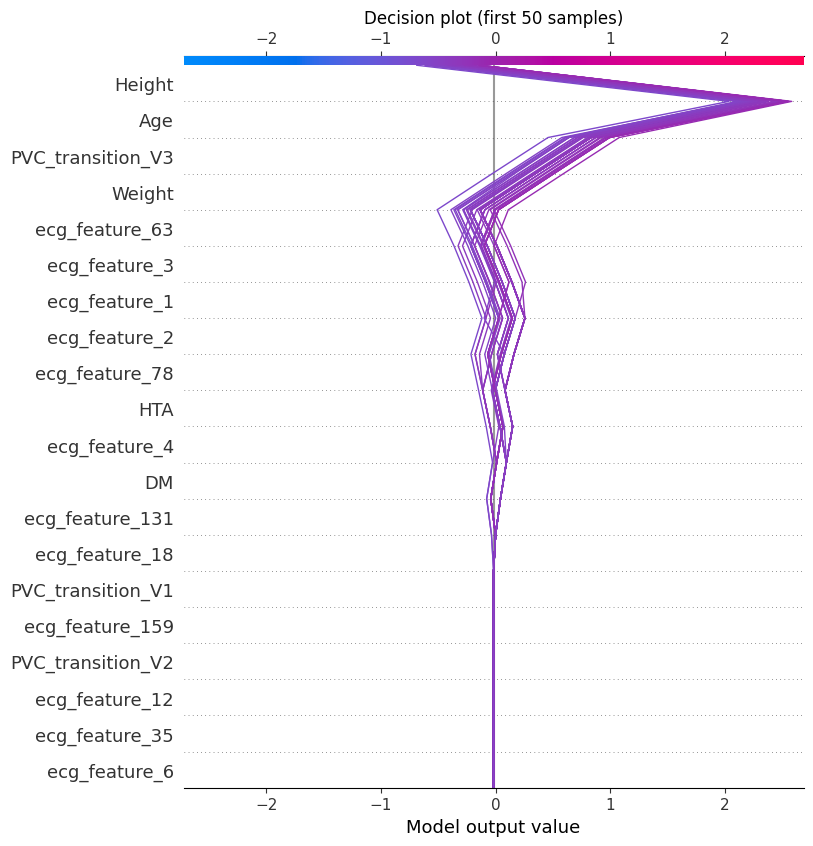


--- 6) Partial‐dependence plots for features ['ecg_feature_3', 'Age'] ---


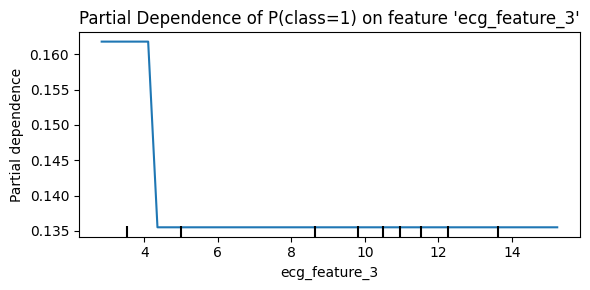

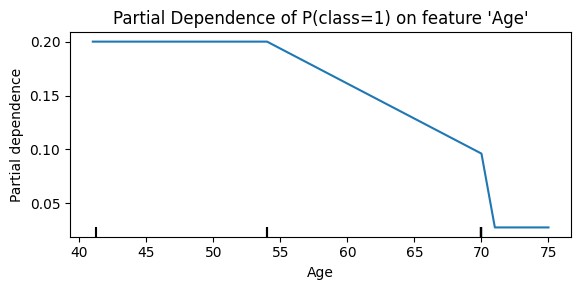


=== Done interpreting model ===



In [9]:
model_c = xgb.XGBClassifier()
model_c.load_model("models/model_c/xgb_best_optuna.json")

feature_names_c = model_c.get_booster().feature_names

# Subset X_test_C to only those columns, in the correct order, this is to ensure compatibility
X_test_C_test = X_test_C[feature_names_c]

interpret_model_full(
    model=model_c,
    X_test=X_test_C_test,
    y_test=y_test_C,
    class_names=['COMMISURE', 'RCC'],
    force_plot_indices=[0, 5, 13],
    max_summary_features=17,
    pdp_features=['ecg_feature_3', 'Age'],
    decision_plot_n=50,
)